# Install Packages

In [47]:
# #SAM
# !pip install git+https://github.com/facebookresearch/segment-anything.git
# #Transformers
# !pip install -q git+https://github.com/huggingface/transformers.git?

# #Datasets to prepare data and monai if you want to use special loss functions
!pip install datasets
!pip install -q monai
# #Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
# !pip install patchify

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 MB 59.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 129.9 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.3/124.3 kB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.6/301.6 kB 33.5 MB/s eta 0:00:00


In [23]:
# !pip install tqdm
# !pip install rasterio
# !pip install opencv-python
# !pip install matplotlib
# !pip install tifffile
# !pip install patchify
# !pip install scipy
# !pip install transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 58.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 775.1/775.1 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 73.8 MB/s eta 0:00:00:00:01


**Finetuning this pipeline on NASA Non-Temporal dataset.** 

# Import Packages

In [24]:
import os
from tqdm import tqdm
import random
import rasterio
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tifffile
from patchify import patchify  #Only to handle large images
import torch
from scipy import ndimage

from torch.utils.data import DataLoader
from PIL import Image
from transformers import SamProcessor
from transformers import SamModel 
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

# Read Train and Validation set

In [29]:
train_base_path = "/satellite_imaging/SAM_Model/Data/NASA-Temporal/training_chips/"
val_base_path = "/satellite_imaging/SAM_Model/Data/NASA-Temporal/validation_chips/"

In [30]:
train_merged_tiffs = [i for i in os.listdir(train_base_path) if ('merged' in i) and (i.startswith('._chip')==False)]
train_masks_tiffs = [i.replace("_merged.tif", ".mask.tif") for i in train_merged_tiffs if i.replace("_merged.tif", ".mask.tif") in os.listdir(train_base_path)]

val_merged_tiffs = [i for i in os.listdir(val_base_path) if ('merged' in i) and (i.startswith('._chip')==False)]
val_masks_tiffs = [i.replace("_merged.tif", ".mask.tif") for i in val_merged_tiffs if i.replace("_merged.tif", ".mask.tif") in os.listdir(val_base_path)]

if len(train_merged_tiffs)==len(train_masks_tiffs):
    print(f"Found {len(train_merged_tiffs)} Images and respective masks in Training set! ")

if len(val_merged_tiffs)==len(val_masks_tiffs):
    print(f"Found {len(val_merged_tiffs)} Images and respective masks in Validation set!")
diff_tiffs = len(set(val_merged_tiffs) - set(train_merged_tiffs)) - len(val_merged_tiffs)
print(f"Found {diff_tiffs} matching images in Train and Valid sets")

train_merged_tiffs = [train_base_path+i for i in train_merged_tiffs]
train_masks_tiffs = [train_base_path+i for i in train_masks_tiffs]

val_merged_tiffs = [val_base_path+i for i in val_merged_tiffs]
val_masks_tiffs = [val_base_path+i for i in val_masks_tiffs]

train_paired_paths = [(train_merged_tiffs[i], train_masks_tiffs[i]) for i in range(0, len(train_merged_tiffs))]
val_paired_paths = [(val_merged_tiffs[i], val_masks_tiffs[i]) for i in range(0, len(val_merged_tiffs))]

Found 3083 Images and respective masks in Training set! 
Found 771 Images and respective masks in Validation set!
Found 0 matching images in Train and Valid sets


In [31]:
!pwd

/satellite_imaging/SAM_Model


In [32]:
def get_images_masks_from_path(paired_path):
    total_images = []
    total_masks = []
    
    for img_path, mask_path in tqdm(paired_path):
        
        with rasterio.open(img_path) as img:
            img_data = img.read()
        img.close()
    
        with rasterio.open(mask_path) as img:
            mask_data = img.read()
        img.close()
        mask_data[mask_data == 8] = 255
        mask_data[mask_data != 255] = 0
        mask_data[mask_data == 255] = 1
        
        mask_data = np.transpose(mask_data, (1, 2, 0))
        mask_data = cv2.resize(mask_data, (256, 256))
        mask_data = np.squeeze(mask_data)
        
        temporal_images = [img_data[0:6], img_data[6:12], img_data[12:]]
        
        for t_img in temporal_images:
            red_band = t_img[2]
            green_band = t_img[1]
            blue_band = t_img[0]
    
            # Combine bands to create the RGB image
            rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
            rgb_image = rgb_image.astype(np.float16)
    
            # Normalize each channel separately
            normalized_image = (rgb_image/rgb_image.max())*255
            normalized_image = np.uint8(normalized_image)
            normalized_image = cv2.resize(normalized_image, (256, 256))
            
            total_images.append(normalized_image)
            total_masks.append(mask_data)
    return total_images, total_masks
    

In [33]:
# Extract Train Images in Numpy format
train_images, train_masks = get_images_masks_from_path(train_paired_paths)

# Extract Validation Images in Numpy format
val_images, val_masks = get_images_masks_from_path(val_paired_paths)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 771/771 [00:25<00:00, 29.93it/s]


In [34]:
len(train_images), len(train_masks), len(val_images), len(val_masks)

(9249, 9249, 2313, 2313)

# Pre-Process Input Images

In [35]:
def get_positive_pix_perc(mask):
    count_ones = np.count_nonzero(mask == 1)
    return count_ones/(256*256)

In [36]:
valid_indices = [i for i, mask in enumerate(train_masks) if get_positive_pix_perc(mask) >= 0.1]

train_images = [train_images[i] for i in valid_indices]
train_masks = [train_masks[i] for i in valid_indices]

len(train_images), len(train_masks)

(1905, 1905)

In [37]:
valid_indices = [i for i, mask in enumerate(val_masks) if get_positive_pix_perc(mask) >= 0.2]

val_images = [val_images[i] for i in valid_indices]
val_masks = [val_masks[i] for i in valid_indices]

len(val_images), len(val_masks)

(219, 219)

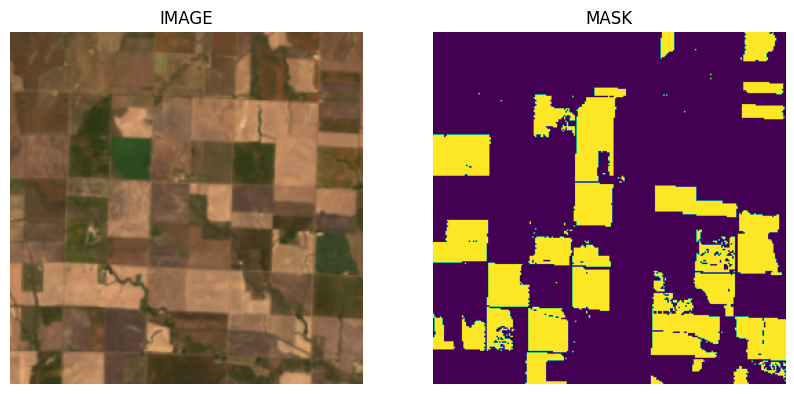

In [45]:
val=np.random.randint(0,len(train_images)-1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(train_images[val])
axes[0].axis("off")
axes[0].set_title("IMAGE")

axes[1].imshow(np.expand_dims(train_masks[val], axis=-1))
axes[1].axis("off")
axes[1].set_title("MASK");

In [94]:
from datasets import Dataset

# Convert the NumPy arrays to Pillow images and store them in a dictionary
train_dataset_dict = {
    "image": [Image.fromarray(img) for img in train_images],
    "label": [Image.fromarray(mask) for mask in train_masks],
    "is_train":[True]*len(train_images)
}

val_dataset_dict = {
    "image": [Image.fromarray(img) for img in val_images],
    "label": [Image.fromarray(mask) for mask in val_masks],
    "is_train":[False]*len(val_images)
}

# Create the dataset using the datasets.Dataset class
train_dataset = Dataset.from_dict(train_dataset_dict)
val_dataset = Dataset.from_dict(val_dataset_dict)

In [53]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]
  return bbox

In [54]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])
    is_train = item['is_train']

    # get bounding box prompt
    if is_train:
        prompt = get_bounding_box(ground_truth_mask)
    else:
        prompt = [1, 1, 255, 255]

    np_image = np.array(image)
    
    # prepare image and prompt for the model
    inputs = self.processor(np_image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [57]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [56]:
processor

SamProcessor:
- image_processor: SamImageProcessor {
  "_valid_processor_keys": [
    "images",
    "segmentation_maps",
    "do_resize",
    "size",
    "mask_size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "do_pad",
    "pad_size",
    "mask_pad_size",
    "do_convert_rgb",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_convert_rgb": true,
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "SamImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "mask_pad_size": {
    "height": 256,
    "width": 256
  },
  "mask_size": {
    "longest_edge": 256
  },
  "pad_size": {
    "height": 1024,
    "width": 1024
  },
  "processor_class": "SamProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1024
  }
}


{
  "

In [91]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset = train_dataset, processor = processor)
val_dataset = SAMDataset(dataset = val_dataset, processor = processor)

In [92]:
train_dataset[0]['pixel_values'].shape

KeyError: 'image'

In [66]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


In [67]:
example = val_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


- **Create a DataLoader instance for the training and Validation dataset.**

In [68]:
len(train_dataset), len(val_dataset)

(1905, 219)

In [75]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=False)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, drop_last=False)

In [76]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([8, 3, 1024, 1024])
original_sizes torch.Size([8, 2])
reshaped_input_sizes torch.Size([8, 2])
input_boxes torch.Size([8, 1, 4])
ground_truth_mask torch.Size([8, 256, 256])


In [77]:
batch = next(iter(val_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([8, 3, 1024, 1024])
original_sizes torch.Size([8, 2])
reshaped_input_sizes torch.Size([8, 2])
input_boxes torch.Size([8, 1, 4])
ground_truth_mask torch.Size([8, 256, 256])


In [78]:
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [79]:
model

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [80]:
# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [82]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceFocalLoss(sigmoid=True, squared_pred=True, reduction='mean')

In [83]:
def compute_validation_loss(current_model, val_ds):
    batch_losses = []
    total_batches = len(val_ds)
    for batch in tqdm(val_ds):
      # forward pass
      outputs = current_model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))
      batch_losses.append(loss.item())
    return mean(batch_losses)

In [86]:
!pwd

/satellite_imaging/SAM_Model


In [108]:
#Training loop
num_epochs = 350
best_val_loss = 999
epoch_wise_train_loss = []
epoch_wise_val_loss = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_train_losses = []
    for batch in tqdm(train_dataloader):
        
        # forward pass
        outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
        # compute train loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_masks = batch["ground_truth_mask"].float().to(device)
        loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))


        # backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()

        # optimize
        optimizer.step()
        epoch_train_losses.append(loss.item())
        
    # Compute Batch loss
    val_loss =  compute_validation_loss(model, val_dataloader)

    if val_loss < best_val_loss:
        print(f'*****Loss Improved from {best_val_loss} to {val_loss}')
        best_val_loss = val_loss
        # Save the model's state dictionary to a file
        torch.save(model.state_dict(), "/satellite_imaging/SAM_Model/Models/mito_model_checkpoint_dice_focal.pth")
        
    epoch_wise_train_loss.append(mean(epoch_train_losses))
    epoch_wise_val_loss.append(val_loss)
    print(f'For EPOCH: {epoch} ===> Train_loss: {mean(epoch_train_losses)}, Val_loss: {val_loss}\n\n')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


*****Loss Improved from 999 to 0.6085520450557981
For EPOCH: 0 ===> Train_loss: 0.534645960794832, Val_loss: 0.6085520450557981




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


*****Loss Improved from 0.6085520450557981 to 0.6080503250871386
For EPOCH: 1 ===> Train_loss: 0.5307792568555936, Val_loss: 0.6080503250871386




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.01it/s]


*****Loss Improved from 0.6080503250871386 to 0.6070406373058047
For EPOCH: 2 ===> Train_loss: 0.5289841618498, Val_loss: 0.6070406373058047




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.01it/s]


For EPOCH: 3 ===> Train_loss: 0.5250919993701839, Val_loss: 0.6073482717786517




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 4 ===> Train_loss: 0.521717995654589, Val_loss: 0.6245063511388642




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.03s/it]


For EPOCH: 55 ===> Train_loss: 0.44242587972385616, Val_loss: 0.6735753566026688




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 73 ===> Train_loss: 0.4240026008883281, Val_loss: 0.6935165183884757




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.00s/it]


For EPOCH: 74 ===> Train_loss: 0.4249316485107693, Val_loss: 0.7081132446016584




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.03s/it]


For EPOCH: 75 ===> Train_loss: 0.4244834477681994, Val_loss: 0.7182079766477857




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 76 ===> Train_loss: 0.4200852181622174, Val_loss: 0.7250009477138519




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.01it/s]


For EPOCH: 77 ===> Train_loss: 0.41965584001780554, Val_loss: 0.6941880817924228




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.00it/s]


For EPOCH: 78 ===> Train_loss: 0.41775413655586324, Val_loss: 0.7120634956019265




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.00s/it]


For EPOCH: 79 ===> Train_loss: 0.41753963097368824, Val_loss: 0.7094407443489347




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 80 ===> Train_loss: 0.41737256139890916, Val_loss: 0.7160710394382477




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 81 ===> Train_loss: 0.41656482743418866, Val_loss: 0.7151724249124527




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 82 ===> Train_loss: 0.41296159061427895, Val_loss: 0.7032373930726733




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 83 ===> Train_loss: 0.41570776987774105, Val_loss: 0.7350681189979825




 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 216/239 [03:45<00:23,  1.04s/it]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.00it/s]


For EPOCH: 95 ===> Train_loss: 0.4038873959535335, Val_loss: 0.7192594813449043




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 96 ===> Train_loss: 0.3991555869579315, Val_loss: 0.7347782914127622




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 97 ===> Train_loss: 0.39811205452456133, Val_loss: 0.7312380118029458




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.01s/it]


For EPOCH: 98 ===> Train_loss: 0.3987193265345306, Val_loss: 0.7398956077439445




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 99 ===> Train_loss: 0.3988934969802282, Val_loss: 0.7632672509976796




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:27<00:00,  1.02it/s]


For EPOCH: 100 ===> Train_loss: 0.40160856155920227, Val_loss: 0.7458245371069226




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.00s/it]


For EPOCH: 101 ===> Train_loss: 0.3969699592021719, Val_loss: 0.7563571482896805




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.03s/it]


For EPOCH: 102 ===> Train_loss: 0.39437259079023385, Val_loss: 0.7489287704229355




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 103 ===> Train_loss: 0.3939251686489233, Val_loss: 0.7382159893001828




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.02s/it]


For EPOCH: 104 ===> Train_loss: 0.3936742059107106, Val_loss: 0.7521360452686038




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:29<00:00,  1.04s/it]


For EPOCH: 105 ===> Train_loss: 0.39619386208606067, Val_loss: 0.7452829309872219




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:28<00:00,  1.03s/it]


For EPOCH: 106 ===> Train_loss: 0.3914127871082418, Val_loss: 0.7569889085633414




  8%|██████████▎                                                                                                                       | 19/239 [00:20<03:58,  1.08s/it]


KeyboardInterrupt: 

In [ ]:
#torch.save(model.state_dict(), "/segment_anything_geospatial/Models/mito_model_checkpoint_overfit.pth")

In [109]:
best_val_loss

0.6070406373058047

In [32]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [81]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/segment_anything_geospatial/Models/mito_model_checkpoint_overfit.pth"))

<All keys matched successfully>

In [82]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [110]:
my_mito_model=model

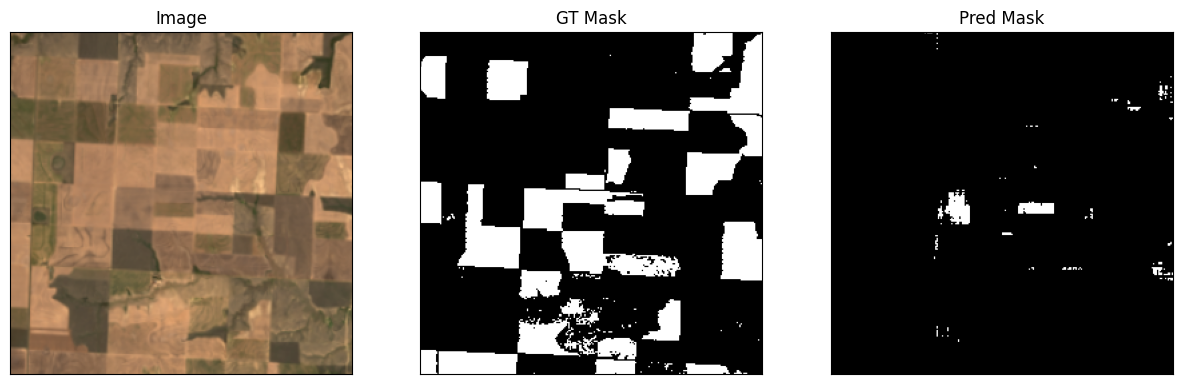

In [118]:
# let's take a random training example
idx = random.randint(0, len(train_images)-1)
#idx = 805, 650, 582

# load image
test_image = train_dataset[idx]["image"]
test_image = np.array(test_image)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(train_dataset[idx]["label"])
prompt = [1,1,255,255]
#prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.8).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("GT Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Pred Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [95]:
# let's take a random training example
#val_indexes = [120, 185, 69, 118, 69, 58, 193, 106, 27, 84, 21]
idx = random.choice([120, 185, 69, 118, 69, 58, 193, 106, 27, 84, 21])
#idx = 805, 650, 582

# load image
test_image = val_dataset[idx]["image"]
test_image = np.array(test_image)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(val_dataset[idx]["label"])
prompt = [1,1,255,255]
#prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.8).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("GT Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Pred Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

NameError: name 'my_mito_model' is not defined

# Calculate mask level Recall

In [233]:
def calculateIoU(gtMask, predMask):
    # Calculate the true positives,
    # false positives, and false negatives
    tp = 0
    fp = 0
    fn = 0
    for i in range(len(gtMask)):
        for j in range(len(gtMask[0])):
            if gtMask[i][j] == 1 and predMask[i][j] == 1:
                tp += 1
            elif gtMask[i][j] == 0 and predMask[i][j] == 1:
                fp += 1
            elif gtMask[i][j] == 1 and predMask[i][j] == 0:
                fn += 1
    # Calculate IoU
    iou = tp / (tp + fn)
    return iou

In [240]:
train_ious = []

for idx in tqdm(range(0, len(train_images)-1)):
    
    # load image
    test_image = train_dataset[idx]["image"]
    test_image = np.array(test_image)
    
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(train_dataset[idx]["label"])
    prompt = [1,1,255,255]
    #prompt = get_bounding_box(ground_truth_mask)
    
    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    
    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    my_mito_model.eval()
    
    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.6).astype(np.uint8)
    iou = calculateIoU(ground_truth_mask, medsam_seg)

    train_ious.append(iou)

In [238]:
val_ious = []

for idx in tqdm(range(0, len(val_images)-1)):
    
    # load image
    test_image = val_dataset[idx]["image"]
    test_image = np.array(test_image)
    
    # get box prompt based on ground truth segmentation map
    ground_truth_mask = np.array(val_dataset[idx]["label"])
    prompt = [1,1,255,255]
    #prompt = get_bounding_box(ground_truth_mask)
    
    # prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")
    
    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    my_mito_model.eval()
    
    # forward pass
    with torch.no_grad():
        outputs = my_mito_model(**inputs, multimask_output=False)
    
    # apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    
    # convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.6).astype(np.uint8)
    iou = calculateIoU(ground_truth_mask, medsam_seg)

    val_ious.append(iou)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [01:43<00:00,  2.11it/s]


- **Recall for Threshold 0.8 => Train 56%, Val 20%.**
- **Recall for Threshold 0.7 => Train 62%, Val 25%.**
- **Recall for Threshold 0.6 => Train 68%, Val 29%.**

### Inference on Validation data

In [ ]:
total_val_images = []
total_val_masks = []

for img_path, mask_path in tqdm(val_paired_imgs_masks_paths):
    
    with rasterio.open(img_path) as img:
        img_data = img.read()
    img.close()

    with rasterio.open(mask_path) as img:
        mask_data = img.read()
    img.close()
    mask_data[mask_data == 8] = 255
    mask_data[mask_data != 255] = 0
    mask_data[mask_data == 255] = 1
    
    mask_data = np.transpose(mask_data, (1, 2, 0))
    mask_data = cv2.resize(mask_data, (256, 256))
    mask_data = np.squeeze(mask_data)
    
    temporal_images = [img_data[0:6], img_data[6:12], img_data[12:]]
    
    for t_img in temporal_images:
        red_band = t_img[2]
        green_band = t_img[1]
        blue_band = t_img[0]

        # Combine bands to create the RGB image
        rgb_image = np.dstack((red_band, green_band, blue_band))*1.0
        rgb_image = rgb_image.astype(np.float16)

        # Normalize each channel separately
        normalized_image = (rgb_image/rgb_image.max())*255
        normalized_image = np.uint8(normalized_image)
        normalized_image = cv2.resize(normalized_image, (256, 256))
        
        total_val_images.append(normalized_image)
        total_val_masks.append(mask_data)
    

In [ ]:
len(total_val_images), len(total_val_masks)

In [ ]:
total_val_images[0].shape, total_val_masks[0].shape

In [ ]:
val=np.random.randint(0,len(total_val_images)-1)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

axes[0].imshow(total_val_images[val])
axes[0].axis("off")
axes[0].set_title("IMAGE")

axes[1].imshow(np.expand_dims(total_val_masks[val], axis=-1))
axes[1].axis("off")
axes[1].set_title("MASK")

In [ ]:
# let's take a random training example
idx = random.randint(0, len(total_val_images)-1)
#idx = 805, 650, 582

# load image
test_image = total_val_images[idx]
test_image = np.array(test_image)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(total_val_masks[idx])
prompt = [1,1,255,255]
#prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.95).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("GT Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Pred Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Read and Train on Mitochondria data

In [ ]:
#165 large images as tiff image stack
large_images = tifffile.imread("/segment_anything_geospatial/Data/mito-dataset/training.tif")
large_masks = tifffile.imread("/segment_anything_geospatial/Data/mito-dataset/training_groundtruth.tif")

Now. let us divide these large images into smaller patches for training. We can use patchify or write custom code.

In [ ]:
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256

In [ ]:
all_img_patches = []
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [ ]:
images.shape

Now, let us delete empty masks as they may cause issues later on during training. If a batch contains empty masks then the loss function will throw an error as it may not know how to handle empty tensors.

In [ ]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Let us create a 'dataset' that serves us input images and masks for the rest of our journey.

In [ ]:
np.unique(filtered_masks[0])

In [ ]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [ ]:
dataset

Let us make sure out images and masks (labels) are loading appropriately

In [ ]:
img_num = random.randint(0, filtered_images.shape[0]-1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Get bounding boxes from masks. You can get here directly if you are working with coco style annotations where bounding boxes are captured in a JSON file.

In [ ]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [ ]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    np_image = np.array(image)
    rgb_image = np.repeat(np_image[:, :, np.newaxis], 3, axis=2)
    # prepare image and prompt for the model
    inputs = self.processor(rgb_image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [ ]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

In [ ]:
# Create a DataLoader instance for the training dataset
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

In [ ]:
batch["ground_truth_mask"].shape

In [ ]:
from transformers import SamModel 
model = SamModel.from_pretrained("facebook/sam-vit-base")

In [ ]:
# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [ ]:
from torch.optim import Adam
import monai

# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [ ]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)
      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/segment_anything_geospatial/Models/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/segment_anything_geospatial/Models/mito_model_checkpoint.pth"))

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

In [ ]:
idx

In [ ]:
# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[1377]["image"]
test_image = np.array(test_image)
test_image = np.repeat(test_image[:, :, np.newaxis], 3, axis=2)

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[1377]["label"])
prompt = [1,1,255,255]
#prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))

# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.9).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(ground_truth_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("GT Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/segment_anything_geospatial/Data/training.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

In [ ]:
patches.shape

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model
np_image = np.array(single_patch)
rgb_image = np.repeat(np_image[:, :, np.newaxis], 3, axis=2)

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(rgb_image, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()